In [1]:
import sys
sys.path.append("..")

# Plots for Acta Astronautica Submission

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import pickle
import pathlib
import random
import wandb
import copy
from pathlib import Path

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

from lib.read_data import *
from lib.stats_utils import cErrorMetrics, cStationary
from lib.plot_utils import GridStrategy
from lib.solar_flux_time_series_forecasting import AttrDict
from lib.sweep_ensemble_utils import *

wandb: Offline run mode, not syncing to the cloud.
wandb: W&B syncing is set to `offline` in this directory.  Run `wandb online` to enable cloud syncing.


In [3]:
#!wandb login <add your key here>

In [4]:
plotdir = "plots/AA"

ddir = pathlib.Path(plotdir)
ddir.mkdir(parents=True, exist_ok=True)

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager

In [6]:
plt.rcParams.update(plt.rcParamsDefault)

In [7]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

https://matplotlib.org/3.1.0/gallery/color/named_colors.html

In [9]:
col = {
    "b" : "tab:blue",
    "r" : "tab:red",
    "g" : "g",
    "o" : "orange",
    "x" : "tab:pink",
}

## Solar activity time series

In [10]:
destdir = "../data/cls"
ldate = "1950-01-01"
udate = "2021-01-01"

In [11]:
# cnes data
obj = cCLS_CNES(verb=True)
dfa_cls = obj.fget_archive_data(destdir, ldate, udate)
dfa_cls

,ds,f30,f30_c,f30_p,f30_f,f15,f15_c,f15_p,f15_f,f10.7,...,f10.7_p,f10.7_f,f8,f8_c,f8_p,f8_f,f3.2,f3.2_c,f3.2_p,f3.2_f
0,1951-11-01,70.4,70.4,1.9,2,87.1,87.1,2.5,2,107.3,...,3.6,0,111.6,111.6,3.1,2,291.7,291.7,3.7,2
1,1951-11-02,69.3,69.3,1.9,2,85.2,85.2,2.5,2,104.7,...,3.6,0,109.2,109.2,3.1,2,289.9,289.9,3.7,2
2,1951-11-03,68.5,68.5,1.9,2,84.2,84.2,2.5,2,106.1,...,3.6,2,108.7,108.7,3.1,2,289.9,289.9,3.7,2
3,1951-11-04,65.9,65.9,1.9,2,80.7,80.7,2.5,2,107.2,...,3.6,0,106.4,106.4,3.1,2,289.7,289.7,3.7,2
4,1951-11-05,71.1,71.1,1.9,2,88.1,88.1,2.5,2,114.0,...,3.6,0,112.0,112.0,3.1,2,289.9,289.9,3.7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25260,2020-12-28,61.0,61.0,1.2,0,80.0,80.0,1.8,0,87.0,...,2.4,1,94.0,94.0,1.9,0,275.0,275.0,2.0,0
25261,2020-12-29,60.0,60.0,1.2,0,77.0,77.0,1.8,0,84.0,...,2.4,1,93.0,93.0,1.9,0,276.0,276.0,2.0,0
25262,2020-12-30,59.0,59.0,1.2,0,77.0,77.0,1.8,0,83.0,...,2.4,1,92.0,92.0,1.9,0,274.0,274.0,2.0,0
25263,2020-12-31,56.2,56.2,1.2,2,74.0,74.0,1.8,0,81.0,...,2.4,1,90.0,90.0,1.9,0,274.0,274.0,2.0,0


In [12]:
index = "f10.7"
dfa_cls = dfa_cls[['ds',index]]
dfa_cls = dfa_cls.set_index("ds")
dfa_cls

,f10.7
ds,
1951-11-01,107.3
1951-11-02,104.7
1951-11-03,106.1
1951-11-04,107.2
1951-11-05,114.0
...,...
2020-12-28,87.0
2020-12-29,84.0
2020-12-30,83.0


In [13]:
# esa
dataobj = cESA_SWE()
dfa_esa = dataobj.fget_data(filenames="../data/archive/F10.7DailyObservedFluxDensity.txt")["f10_7"]
dfa_esa.set_index('ds', inplace=True)
df_lim = dfa_esa[ldate:udate]
df_daily = dataobj.fget_daily(df_lim, "20:00")
dfa_esa  = dataobj.fmissing_data(df_daily, "interp_linear")
dfa_esa

,y
ds,
1950-01-01,152.0
1950-01-02,153.5
1950-01-03,155.0
1950-01-04,150.0
1950-01-05,153.0
...,...
2020-12-27,87.8
2020-12-28,87.2
2020-12-29,84.2


In [14]:
# get cls flags
obj = cCLS_CNES(verb=True)
dfa_flags = obj.fget_archive_data("../data/cls", ldate, udate)
index = "f10.7_f"
dfa_flags = dfa_flags[['ds',index]]
dfa_flags = dfa_flags.set_index("ds")
dfa_flags

,f10.7_f
ds,
1951-11-01,0
1951-11-02,0
1951-11-03,2
1951-11-04,0
1951-11-05,0
...,...
2020-12-28,1
2020-12-29,1
2020-12-30,1


In [15]:
# create dataframe of esa_true, cls_true, cls_flag
# investigate where y_cls_true and y_esa_true deviate significantly
dfx = pd.merge(dfa_esa, dfa_cls, on="ds")
dfx = dfx.merge(dfa_flags, on="ds")
dfx["diff"] = np.abs(dfx["f10.7"] - dfx["y"])
dfx

,y,f10.7,f10.7_f,diff
ds,,,,
1951-11-01,107.0,107.3,0,0.3
1951-11-02,104.0,104.7,0,0.7
1951-11-03,105.5,106.1,2,0.6
1951-11-04,107.0,107.2,0,0.2
1951-11-05,114.0,114.0,0,0.0
...,...,...,...,...
2020-12-27,87.8,88.0,1,0.2
2020-12-28,87.2,87.0,1,0.2
2020-12-29,84.2,84.0,1,0.2


In [16]:
# 6 data points where the value is large (e.g. > 400) and difference between esa and cls is large (> 50 or 100)
x = dfx[dfx["y"] > 400][dfx["diff"] > 100]
x

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,y,f10.7,f10.7_f,diff
ds,,,,
2001-04-06,563.0,191.6,0,371.4
2001-12-28,655.0,263.5,0,391.5
2003-11-04,560.0,168.5,0,391.5
2005-09-09,707.6,99.2,0,608.4
2006-12-06,573.4,102.8,0,470.6
2011-03-07,938.6,151.9,0,786.7


In [17]:
# generate dictionary of values to replace
esa = x["y"].values
cls = x["f10.7"].values
repl = dict(zip(esa,cls))
repl

{563.0: 191.6,
 655.0: 263.5,
 560.0: 168.5,
 707.6: 99.2,
 573.4: 102.8,
 938.6: 151.9}

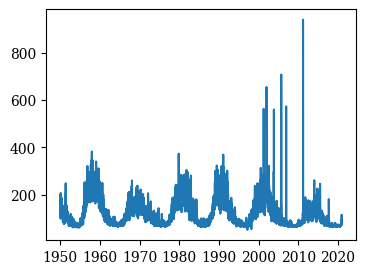

In [18]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(dfa_esa)
plt.show()

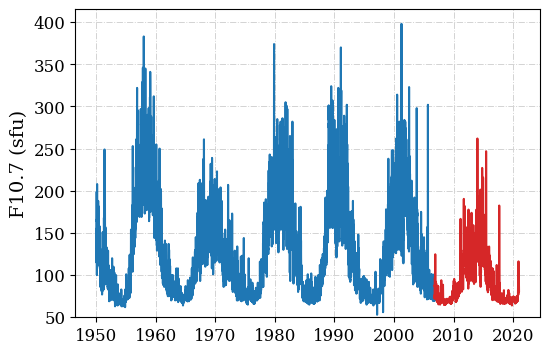

In [19]:
df = dfa_esa
#df = dfa_cls

# replace anomalous spikes in data
for i in repl.keys():
    df["y"] = df["y"].replace(i, repl[i])

# "2017-01-01", "2005-01-01", 2016-11-26, 2006-10-21
rel_fs = 12

fig, ax = plt.subplots(figsize=(6,4)) #(5,4)
ax.plot(df[:"2006-10-21"], col["b"])
ax.plot(df["2006-10-21":], col["r"])

ax.tick_params(axis='x', labelsize=rel_fs)
ax.tick_params(axis='y', labelsize=rel_fs)

ax.set_ylabel("F10.7 (sfu)", fontsize=rel_fs+2)

#ax.set_xlim((dt.datetime(1950,1,1),None))
ax.set_ylim((50,None))
ax.grid(linestyle='-.', linewidth=0.7, color="lightgrey", zorder=0)

#plotname = "{}/Fig2_f10.7_timeseries_2006".format(plotdir) # f10.7, f10.7_2005, f10.7_2016
#plt.savefig("{}.pdf".format(plotname), format='pdf', dpi=1200, bbox_inches="tight", pad_inches=0, transparent=True)
#plt.savefig("{}.png".format(plotname), format='png', dpi=1200, bbox_inches="tight", pad_inches=0, transparent=True)

plt.show()

## Get Data (& Ensemble)

### Data from wandb files or api

In [20]:
entity  = "stardust-r"
project = "deep-learning-space-weather-forecasting"

# wandb sweep ids (api not working for these sweeps as wandb.watch(all) too large)
#sweeps = ["inztzkl4", "607ppbji", "9ihcleuh", "2ajetr8i"]

# path to manual id text files
sweeps = ["./wandb_ensemble/ensemble/ensembleH3.txt", "./wandb_ensemble/ensemble/ensembleH5H7.txt", 
          "./wandb_ensemble/ensemble/ensembleH10H14.txt", "./wandb_ensemble/ensemble/ensembleH21H27.txt"]

# path to downloaded sweep run files
datadir = "../data/wandb_ensemble/ensemble"

In [21]:
%%time
# dictionary of horizons then run_ids
data_valid = fget_pickled(sweeps, datadir, entity, project, pklname="models/preds_test.pickle", 
                          download=False, sweep_type="txt")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
../lib/sweep_ensemble_utils.py:92: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(sweep_i, delimiter=", ")


./wandb_ensemble/ensemble/ensembleH3.txt 90
./wandb_ensemble/ensemble/ensembleH5H7.txt 180
./wandb_ensemble/ensemble/ensembleH10H14.txt 180
./wandb_ensemble/ensemble/ensembleH21H27.txt 180
CPU times: user 329 ms, sys: 2.26 s, total: 2.59 s
Wall time: 2.58 s


In [22]:
%%time
# for now this is not logged with wandb: must be manually generated by downloading model file and applying to training data
data_train = fget_pickled(sweeps, datadir, entity, project, pklname="models/preds_train.pickle", 
                          download=False, sweep_type="txt")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


./wandb_ensemble/ensemble/ensembleH3.txt 90
./wandb_ensemble/ensemble/ensembleH5H7.txt 180
./wandb_ensemble/ensemble/ensembleH10H14.txt 180
./wandb_ensemble/ensemble/ensembleH21H27.txt 180
CPU times: user 1.73 s, sys: 9.08 s, total: 10.8 s
Wall time: 10.8 s


In [23]:
data_valid[3]["t8r3v9or"]

{'preds': array([[0.09384836, 0.09275597, 0.09365283],
        [0.09831063, 0.09721904, 0.09787896],
        [0.10078903, 0.09968247, 0.10018463],
        ...,
        [0.11686298, 0.11467203, 0.11406119],
        [0.11711943, 0.11463648, 0.1134624 ],
        [0.11596964, 0.11376598, 0.11256385]], dtype=float32),
 'targs': array([[0.10556812, 0.10712267, 0.1079706 ],
        [0.10712267, 0.1079706 , 0.10570944],
        [0.1079706 , 0.10570944, 0.10556812],
        ...,
        [0.12422272, 0.1240814 , 0.12323347],
        [0.1240814 , 0.12323347, 0.11899378],
        [0.12323347, 0.11899378, 0.11701526]]),
 'inp': array([[0.10825325, 0.10839457, 0.10924251, ..., 0.09821933, 0.09836066,
         0.1004805 ],
        [0.10839457, 0.10924251, 0.1079706 , ..., 0.09836066, 0.1004805 ,
         0.10556812],
        [0.10924251, 0.1079706 , 0.10811193, ..., 0.1004805 , 0.10556812,
         0.10712267],
        ...,
        [0.11644997, 0.116026  , 0.11517807, ..., 0.12210288, 0.12351611,
   

In [24]:
#horizons = [3,5,7,10,14,21,27]
horizons = list(sorted(data_valid.keys()))
horizons

[3, 5, 7, 10, 14, 21, 27]

### Compare to other metrics

In [25]:
# config to get dataframe of external forecasts
# IAC "2017-01-01"/"2005-01-01" -- "2020-01-01"
# AA  "2016-11-25"/"2004-12-31" -- "2021-01-01"/"2020-10-01" ["esa", "cls"]/["cls"]

user_config = {
        
    # data
    "data_src"            : "esa",              # use esa archive data to learn from (to be implemented + other options)
    "data_comp"           : ["cls"],     # external forecasts to compare to (to be implemented) ["esa", "cls"]
    "date_llim"           : "1949-12-31",       # lower date cut for data for training/testing
    "date_ulim"           : "2021-01-01",       # upper date cut for data for training/testing
    "get_daily_method"    : "20:00",            # (for esa archive data) "interp", "20:00", False
    "missing_data_method" : "interp_linear",    # (for esa archive data) "interp_linear", "pad", False
    
    # esa data
    "esa_archive_fname"  : "../data/archive/F10.7DailyObservedFluxDensity.txt",      # esa archived data to learn from
    "esa_forecast_fname" : "../data/forecast/F10.7_IndexForecast27day_BGS_2017.txt",  # esa forecast data to compare to
    "esa_archive_key"    : "f10_7",                                       # key for datadict of filenames
    "esa_forecast_key"   : "F107_NMH_esforc",                             # key for datadict of filenames
    
    # cls-cnes data
    "cls_datadir"        : "../data/cls",           # directory where data is downloaded to
    "cls_key"            : "f10.7",                  # key for column header
    "cls_forecast_ldate" : "2004-12-31",             # lower date to download cls from for forecast files
    "cls_forecast_udate" : "2020-10-01",             # upper date to download cls to for forecast files
    "cls_adj"            : False,                    # adjusted data?
}

# read in config
config = AttrDict()
config.update(user_config)

In [446]:
%%time
dfo = fget_external_forecasts(config)

../lib/read_data.py:450: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df.ds >= ldate][df.ds <= udate]


CPU times: user 2min 42s, sys: 2.15 s, total: 2min 44s
Wall time: 2min 44s


In [447]:
df = dfo.dropna().reset_index(drop=True)
df

,gendate,ds,y_cls,y_cls_true,persistence_cls,y_esa_true,persistence_esa
0,2005-01-01,2005-01-01,96.5,99.0,98.5,98.9,98.5
1,2005-01-01,2005-01-02,94.8,100.1,98.5,100.0,98.5
2,2005-01-01,2005-01-03,93.7,94.2,98.5,94.2,98.5
3,2005-01-01,2005-01-04,92.6,88.1,98.5,88.0,98.5
4,2005-01-01,2005-01-05,92.0,88.3,98.5,86.9,98.5
...,...,...,...,...,...,...,...
172585,2020-10-01,2020-10-26,75.1,83.9,77.8,75.0,73.3
172586,2020-10-01,2020-10-27,75.2,88.8,77.8,82.4,73.3
172587,2020-10-01,2020-10-28,75.1,92.8,77.8,87.6,73.3
172588,2020-10-01,2020-10-29,75.0,90.5,77.8,84.6,73.3


In [448]:
%%time
# get CNES precision
dataobj_cls = cCLS_CNES()
udate_a = (dt.datetime.strptime(config.cls_forecast_udate, "%Y-%m-%d") + dt.timedelta(days=30)).strftime("%Y-%m-%d")
dfa_cls = dataobj_cls.fget_archive_data(config.cls_datadir, config.cls_forecast_ldate, udate_a)
dfa_cls = dfa_cls[['ds',config.cls_key]]
dfa_cls = dfa_cls.set_index("ds")
# read in forecast data and restrict to key variable
dff_cls = dataobj_cls.fget_forecast_data(config.cls_datadir, config.cls_forecast_ldate, config.cls_forecast_udate)
dff_cls1 = dff_cls[['gendate', 'ds', "{}_c".format(config.cls_key), "{}_p".format(config.cls_key)]]
#dff_cls1
# merge on gendate and ds
df = pd.merge(df, dff_cls1, on=['gendate', 'ds'])
df

../lib/read_data.py:450: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df.ds >= ldate][df.ds <= udate]


CPU times: user 2min 35s, sys: 1.92 s, total: 2min 37s
Wall time: 2min 37s


,gendate,ds,y_cls,y_cls_true,persistence_cls,y_esa_true,persistence_esa,f10.7_c,f10.7_p
0,2005-01-01,2005-01-01,96.5,99.0,98.5,98.9,98.5,96.5,5.7
1,2005-01-01,2005-01-02,94.8,100.1,98.5,100.0,98.5,94.8,7.2
2,2005-01-01,2005-01-03,93.7,94.2,98.5,94.2,98.5,93.7,8.9
3,2005-01-01,2005-01-04,92.6,88.1,98.5,88.0,98.5,92.6,10.4
4,2005-01-01,2005-01-05,92.0,88.3,98.5,86.9,98.5,92.0,11.7
...,...,...,...,...,...,...,...,...,...
172585,2020-10-01,2020-10-26,75.1,83.9,77.8,75.0,73.3,75.1,6.9
172586,2020-10-01,2020-10-27,75.2,88.8,77.8,82.4,73.3,75.2,7.0
172587,2020-10-01,2020-10-28,75.1,92.8,77.8,87.6,73.3,75.1,7.2
172588,2020-10-01,2020-10-29,75.0,90.5,77.8,84.6,73.3,75.0,7.3


In [449]:
# replace anomalous spikes in data
print(repl)
for i in repl.keys():
    df["y_esa_true"] = df["y_esa_true"].replace(i, repl[i])

{563.0: 191.6, 655.0: 263.5, 560.0: 168.5, 707.6: 99.2, 573.4: 102.8, 938.6: 151.9}


In [26]:
# TO/FROM PICKLE
fname = "{}/ext_df_{}-{}.pkl".format(plotdir, config.cls_forecast_ldate, config.cls_forecast_udate)
#df.to_pickle(fname)
df = pd.read_pickle(fname)
df

,gendate,ds,y_cls,y_cls_true,persistence_cls,y_esa_true,persistence_esa,f10.7_c,f10.7_p
0,2005-01-01,2005-01-01,96.5,99.0,98.5,98.9,98.5,96.5,5.7
1,2005-01-01,2005-01-02,94.8,100.1,98.5,100.0,98.5,94.8,7.2
2,2005-01-01,2005-01-03,93.7,94.2,98.5,94.2,98.5,93.7,8.9
3,2005-01-01,2005-01-04,92.6,88.1,98.5,88.0,98.5,92.6,10.4
4,2005-01-01,2005-01-05,92.0,88.3,98.5,86.9,98.5,92.0,11.7
...,...,...,...,...,...,...,...,...,...
172585,2020-10-01,2020-10-26,75.1,83.9,77.8,75.0,73.3,75.1,6.9
172586,2020-10-01,2020-10-27,75.2,88.8,77.8,82.4,73.3,75.2,7.0
172587,2020-10-01,2020-10-28,75.1,92.8,77.8,87.6,73.3,75.1,7.2
172588,2020-10-01,2020-10-29,75.0,90.5,77.8,84.6,73.3,75.0,7.3


In [27]:
# get limits of external forecasts to limit N-BEATS forecast
lcompdate, ucompdate = df.gendate.iloc[0].strftime('%Y-%m-%d'), df.gendate.iloc[-1].strftime('%Y-%m-%d')
lcompdate, ucompdate

('2005-01-01', '2020-10-01')

### Ensemble N-BEATS

In [28]:
# need to cut data so same length or cut at given date range (to be compared with esa etc)
limit_date = True

mode = "mean"
#mode = "boosting_regressor" # "mean", median", "boosting_regressor"
#alpha = 0.95 # if boosting_regressor

# read from pickled file (need for "boosting_regressor" as slow to train)
use_pickle = False

if mode == "boosting_regressor":
    fname = "./wandb_ensemble/ensemble/ensemble_preds_{}_{}_{}-{}.pickle".format(mode, alpha, lcompdate, ucompdate)
else:
    fname = "./wandb_ensemble/ensemble/ensemble_preds_{}_{}-{}.pickle".format(mode, lcompdate, ucompdate)

In [29]:
%%time
if use_pickle:
    try:
        with open(fname, 'rb') as handle:
            predictions = pickle.load(handle)
            print("Predictions from file.")
    except FileNotFoundError:
        print("Pickle file does not exist.")
        use_pickle = False

if not use_pickle:
    predictions = {}
    
    for horizon in horizons:
        print("Horizon: {}".format(horizon))

        # get training (if learning weights) and validation predictions and targets
        epoch_train, preds_train, targs_train = fget_preds(data_train[horizon])
        epoch_valid, preds_valid, targs_valid = fget_preds(data_valid[horizon], limit_date, lcompdate, ucompdate)
        
        # replace anomalous spikes in data
        for i in repl.keys():
            targs_train = np.where(targs_train==i, repl[i], targs_train)
            targs_valid = np.where(targs_valid==i, repl[i], targs_valid)

        # ensemble and store predictions and uncertainty or prediction interval
        if mode == "boosting_regressor":
            ensemble_preds, ensemble_lower, ensemble_upper = fensemble_boosting_regressor(preds_valid, targs_valid, 
                                                                                          preds_train, targs_train, 
                                                                                          alpha=alpha)
            predictions[horizon] = [epoch_valid, targs_valid, ensemble_preds, ensemble_lower, ensemble_upper]
        else:
            ensemble_preds, ensemble_std = fensemble(preds_valid, mode=mode)
            predictions[horizon] = [epoch_valid, targs_valid, ensemble_preds, ensemble_std]

    # if pickle does not already exist, generate
    if not Path(fname).is_file():
        with open(fname, 'wb') as handle:
            pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)

Horizon: 3
(90, 20729, 3) 1950-01-19 2006-10-20
(90, 5095, 3) 2006-10-21 2020-10-01
Horizon: 5
(90, 20718, 5) 1950-01-31 2006-10-21
(90, 5094, 5) 2006-10-22 2020-10-01
Horizon: 7
(90, 20707, 7) 1950-02-12 2006-10-22
(90, 5093, 7) 2006-10-23 2020-10-01
Horizon: 10
(90, 20690, 10) 1950-03-02 2006-10-23
(90, 5092, 10) 2006-10-24 2020-10-01
Horizon: 14
(90, 20668, 14) 1950-03-26 2006-10-25
(90, 5090, 14) 2006-10-26 2020-10-01
Horizon: 21
(90, 20628, 21) 1950-05-07 2006-10-27
(90, 5088, 21) 2006-10-28 2020-10-01
Horizon: 27
(90, 20595, 27) 1950-06-12 2006-10-30
(90, 5085, 27) 2006-10-31 2020-10-01
CPU times: user 711 ms, sys: 480 ms, total: 1.19 s
Wall time: 1.17 s


In [30]:
predictions

{3: [array(['2006-10-21', '2006-10-22', '2006-10-23', ..., '2020-09-29',
         '2020-09-30', '2020-10-01'], dtype='<U10'),
  array([[74.7, 75.8, 76.4],
         [75.8, 76.4, 74.8],
         [76.4, 74.8, 74.7],
         ...,
         [72.8, 73.3, 72.8],
         [73.3, 72.8, 72.2],
         [72.8, 72.2, 71.8]]),
  array([[71.06446 , 71.79809 , 72.12255 ],
         [73.60816 , 74.55074 , 74.95779 ],
         [75.112946, 75.9987  , 76.39392 ],
         ...,
         [73.46607 , 73.90448 , 73.90744 ],
         [72.80539 , 73.189445, 73.12161 ],
         [72.93094 , 73.342   , 73.27589 ]], dtype=float32),
  array([[4.0189013, 3.717138 , 3.9206488],
         [4.1135974, 3.937798 , 4.109401 ],
         [4.131389 , 3.9968936, 4.1381054],
         ...,
         [4.0255594, 3.753651 , 3.9217544],
         [4.007889 , 3.7048728, 3.8807688],
         [3.9998283, 3.7042885, 3.890099 ]], dtype=float32)],
 5: [array(['2006-10-22', '2006-10-23', '2006-10-24', ..., '2020-09-29',
         '2020-09-30

## Plot Window with Uncertainty

Plot example of forecast over single window, including uncertainty.

In [258]:
# read in archive data in order to also plot lookback

dataobj = cESA_SWE()
dfa_esa = dataobj.fget_data(filenames="../data/archive/F10.7DailyObservedFluxDensity.txt")["f10_7"]
dfa_esa.set_index('ds', inplace=True)
df_lim = dfa_esa[config.date_llim:config.date_ulim]#ldate:udate]
df_daily = dataobj.fget_daily(df_lim, "20:00")
dfa_esa  = dataobj.fmissing_data(df_daily, "interp_linear")
dfa_esa

,y
ds,
1950-01-01,152.0
1950-01-02,153.5
1950-01-03,155.0
1950-01-04,150.0
1950-01-05,153.0
...,...
2020-12-27,87.8
2020-12-28,87.2
2020-12-29,84.2


In [259]:
horizon = 5
lookback = 10

In [260]:
# choose index of window to plot

# get indices of smallest losses
#targs = predictions[horizon][1]
#preds = predictions[horizon][2]
#mses = mean_squared_error(targs.T, preds.T, multioutput="raw_values") # value per window
#best = np.argsort(mses)[:10]
#print(best)

#from random import randrange
#i = randrange(len(predictions[horizon][0]))

i = 2205 # 2205 with 1 std, 2206 with 2 std  # for "2004-12-31" -- "2021-01-01" # 2210, 3988, 2751, 1504, 2204, 4544
#i = 400
print(i) 

2205


In [261]:
epoch = predictions[horizon][0][i]
gendate = dt.datetime.strptime(epoch, "%Y-%m-%d")
udate = gendate - dt.timedelta(days=1)
ldate = gendate - dt.timedelta(days=lookback)
print(epoch, udate, ldate)

lbs   = dfa_esa[ldate:udate].values.flatten()
targs = predictions[horizon][1][i]
preds = predictions[horizon][2][i]
std   = predictions[horizon][3][i]

2012-11-04 2012-11-03 00:00:00 2012-10-25 00:00:00


In [262]:
# get all individual predictions
subdict = data_valid[horizon]
common_idx = []
for run_id in subdict.keys():
    common_idx.append(len(subdict[run_id]["pred_date"]))
idx = min(common_idx)

# get predictions for each run
predsall = []
for run_id in subdict.keys():
    predsall.append(subdict[run_id]["preds_denorm"][-idx:][i])

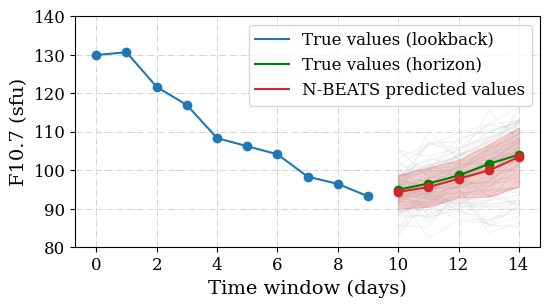

In [264]:
def fplot_scatter(ax, *args, **kwargs):
    ax.plot(*args, **kwargs)
    ax.scatter(*args, **kwargs)

# relative font size
rel_fs = 12

fig, axes = plt.subplots(1, 1, figsize=(6,3))

for pred in predsall:
    axes.plot(range(lookback, lookback + horizon), pred, color="lightgrey", alpha=0.3, linewidth=0.8, zorder=2)

#axes.set_title("{0} (MSE={1:.4f})".format(t1, mse1), fontsize=rel_fs+1)
axes.plot(range(0, lookback), lbs, color=col["b"], label="True values (lookback)", zorder=4)
axes.scatter(range(0, lookback), lbs, color=col["b"], zorder=4)
axes.plot(range(lookback, lookback + horizon), targs, color=col["g"], label="True values (horizon)", zorder=4)
axes.scatter(range(lookback, lookback + horizon), targs, color=col["g"], zorder=4)
axes.plot(range(lookback, lookback + horizon), preds, color=col["r"], label="N-BEATS predicted values", zorder=5)
axes.scatter(range(lookback, lookback + horizon), preds, color=col["r"], zorder=5)

axes.fill_between(range(lookback, lookback + horizon), preds-std, preds+std, color=col["r"], alpha=0.2, zorder=3) #0.2

axes.tick_params(axis='x', labelsize=rel_fs)
axes.tick_params(axis='y', labelsize=rel_fs)

axes.legend(prop={'size': rel_fs}, loc="upper right")

axes.set_xlabel("Time window (days)", fontsize=rel_fs+2)
axes.set_ylabel("F10.7 (sfu)", fontsize=rel_fs+2)

axes.set_ylim((80,140))
axes.grid(linestyle='-.', linewidth=0.7, color="lightgrey", zorder=0)

#plotname = "{}/Fig4_example_window".format(plotdir)
#plt.savefig("{}.pdf".format(plotname), format='pdf', dpi=1200, bbox_inches="tight", pad_inches=0, transparent=True)
#plt.savefig("{}.png".format(plotname), format='png', dpi=1200, bbox_inches="tight", pad_inches=0, transparent=True)

plt.show()

## Generate (Table of) Metrics

In [33]:
# need limit_date == True

In [32]:
def fget_metrics(y_pred, y_true):
    return [fmse(y_true, y_pred), fmape(y_true, y_pred), fcc_pearsonr(y_true, y_pred)[0], 
            frmse(y_true, y_pred), fmae(y_true, y_pred), fme(y_true, y_pred)]

def fget_metrics_std(y_pred, y_true):
    return [fmse_std(y_true, y_pred), fmape_std(y_true, y_pred), fcc_pearsonr_std(y_true, y_pred), 
            frmse_std(y_true, y_pred), fmae_std(y_true, y_pred), fme_std(y_true, y_pred)]

### Option 1: Use each of N-BEATS models separately and average over all days

In [31]:
option = 1

In [32]:
horizons = list(sorted(data_valid.keys()))
horizons

[3, 5, 7, 10, 14, 21, 27]

In [33]:
%%time
# split df by horizon for external forecasts

external_dff_dict = {}

for horizon in horizons:

    # restrict predictions to horizon size
    dff = pd.DataFrame()
    for gendate in np.unique(df.gendate):
        #print(dff[dff.gendate == "2017-01-01"][:horizon])
        dff = dff.append(df[df.gendate == gendate][:horizon], ignore_index = True)

    # drop gendates that don't give full forcast (depends on horizon)
    dff = dff[dff.groupby('gendate').gendate.transform('count')>=horizon].copy()
    
    external_dff_dict[horizon] = dff

CPU times: user 1min 20s, sys: 90.3 ms, total: 1min 20s
Wall time: 1min 20s


In [35]:
%%time
# calculate metrics for n-beats and external forecasts

metricsdict = {}
metricsstddict = {}

predictions_opt1 = {}
predictions_opt1["N-BEATS"] = {}
predictions_opt1["external"] = {}

for h in horizons:
    print("Horizon: ", h)
    
    # get external
    df1 = external_dff_dict[h]
    # get nbeats
    # if mode == "boosting_regressor":
    #    epoch, targs, ensemble_preds, ensemble_lower, ensemble_upper = predictions[horizon]
    # else:
    epochs, targs, ensemble_preds, ensemble_std = predictions[h]
    
    # 1. limit external to same gendate range as N-BEATS
    df2 = df1[df1["gendate"] >= str(epochs[0])][df1["gendate"] <= str(epochs[-1])]
    
    # 2. remove windows from N-BEATS that are missing from external dataframe (due to esa) (not just one missed day but several in a row)
    missing_epochs = np.setdiff1d(epochs, [i.astype(str)[:10] for i in df2.gendate.values])
    idxs = np.array([list(epochs).index(i) for i in missing_epochs])
    #print(missing_epochs)
    
    if len(idxs) == 0:
        epochs1 = epochs
        targs1  = targs
        ensemble_preds1 = ensemble_preds
        ensemble_std1 = ensemble_std
    else:
        epochs1 = np.delete(epochs, idxs, axis=0)
        targs1  = np.delete(targs, idxs, axis=0)
        ensemble_preds1 = np.delete(ensemble_preds, idxs, axis=0)
        ensemble_std1 = np.delete(ensemble_std, idxs, axis=0)
    
    print(int(len(df2)/h), ensemble_preds1.shape) # should have same number of windows
    
    # 3. save into second predictions dictionary (but also with std and maybe cls precision aswell)
    predictions_opt1["N-BEATS"][h]  = [epochs1, targs1, ensemble_preds1, ensemble_std1]
    predictions_opt1["external"][h] = df2
    
    # 4. get external metrics
    metrics_i, metrics_std_i = fget_external_metrics(df2, config)
    metricsdict[h] = metrics_i
    metricsstddict[h] = metrics_std_i
    
    # 5. get N-BEATS metrics from emsembled predictions
    metrics_i = fget_metrics(ensemble_preds1, targs1)
    metricsdict[h]["N-BEATS"] = metrics_i
    metrics_i_std = fget_metrics_std(ensemble_preds1, targs1)
    metricsstddict[h]["N-BEATS"] = metrics_i_std
    
    # 6. see how many runs individually are better than this ensembled average
    subdict = data_valid[h]
    counts  = [0, 0, 0, 0, 0, 0]
    for run_id in subdict.keys():
        metrics_j  = fget_metrics(subdict[run_id]["preds_denorm"], subdict[run_id]["targs_denorm"])
        
        if metrics_j[0] < metrics_i[0]: counts[0] += 1
        if metrics_j[1] < metrics_i[1]: counts[1] += 1
        if metrics_j[2] > metrics_i[2]: counts[2] += 1 # CC should be larger
        if metrics_j[3] < metrics_i[3]: counts[3] += 1
        if metrics_j[4] < metrics_i[4]: counts[4] += 1
        if np.abs(metrics_j[5]) < np.abs(metrics_i[5]): counts[5] += 1 # bias
            
    print("MSE, MAPE, R, RMSE, MAE, ME IMPROVEMENT (/{}), {}, {}, {}, {}, {}, {}".format(len(subdict.keys()), *counts))

Horizon:  3
5095 (5095, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


MSE, MAPE, R, RMSE, MAE, ME IMPROVEMENT (/90), 0, 6, 0, 0, 0, 4
Horizon:  5
5094 (5094, 5)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


MSE, MAPE, R, RMSE, MAE, ME IMPROVEMENT (/90), 0, 4, 0, 0, 0, 10
Horizon:  7
5093 (5093, 7)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


MSE, MAPE, R, RMSE, MAE, ME IMPROVEMENT (/90), 0, 7, 0, 0, 0, 7
Horizon:  10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


5092 (5092, 10)
MSE, MAPE, R, RMSE, MAE, ME IMPROVEMENT (/90), 0, 1, 0, 0, 0, 3
Horizon:  14


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


5090 (5090, 14)
MSE, MAPE, R, RMSE, MAE, ME IMPROVEMENT (/90), 0, 0, 0, 0, 0, 22
Horizon:  21


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


5088 (5088, 21)
MSE, MAPE, R, RMSE, MAE, ME IMPROVEMENT (/90), 0, 0, 0, 0, 0, 8
Horizon:  27


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


5085 (5085, 27)
MSE, MAPE, R, RMSE, MAE, ME IMPROVEMENT (/90), 0, 1, 0, 0, 0, 3
CPU times: user 21.9 s, sys: 1min 54s, total: 2min 16s
Wall time: 4.87 s


### Option 2: per day (mesh N-BEATS forecasts)

In [33]:
option = 2

In [35]:
horizons = list(sorted(data_valid.keys()))
horizons

[3, 5, 7, 10, 14, 21, 27]

In [36]:
# if true, mesh all models, else just choose model H=27
MESH = True

In [37]:
%%time

nbeats_perday_dict = {}

if MESH:
    # MESH OPTION
    # get metric for each day (just considering that day and not the forecast up to that point)  

    for i in range(len(horizons)):
        H = horizons[i]
        H_0 = horizons[i-1]
        if H_0 > H: H_0 = 0
        #print(H, H_0)

        epochs, targs, ensemble_preds, ensemble_std = predictions[H]

        for h in range(H_0, H):
            #print(h)
            nbeats_perday_dict[h+1] = [epochs, targs[:,h], ensemble_preds[:,h], ensemble_std[:,h]]
            
else:
    H = 27

    epochs, targs, ensemble_preds, ensemble_std = predictions[H]

    for h in range (0, H):
        nbeats_perday_dict[h+1] = [epochs, targs[:,h], ensemble_preds[:,h], ensemble_std[:,h]]

CPU times: user 47 µs, sys: 115 µs, total: 162 µs
Wall time: 168 µs


In [38]:
%%time
# for the external forecasts, limit just to single day over forecast
# 3 minutes for 2016-2021
# 11 minutes for 2006-2021

external_perday_dict = {}

for horizon in range(1, 28):
    print(horizon)
    
    # drop gendates that don't give full forcast (depends on horizon)
    dfs = df[df.groupby('gendate').gendate.transform('count')>=horizon].copy()

    # restrict predictions to horizon size
    dff = pd.DataFrame()
    for gendate in np.unique(dfs.gendate):
        #print(gendate)
        dff = dff.append(df[df.gendate == gendate].reset_index(drop=True).loc[horizon-1], ignore_index = True)

    external_perday_dict[horizon] = dff

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
CPU times: user 3min 49s, sys: 113 µs, total: 3min 49s
Wall time: 3min 49s


In [40]:
fname = "{}/external_perday_dict_{}-{}_opt{}.pkl".format(plotdir, config.cls_forecast_ldate, config.cls_forecast_udate, option)
print(fname)
with open(fname, 'wb') as handle:
    pickle.dump(external_perday_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#with open(fname, 'rb') as handle:
#    external_perday_dict = pickle.load(handle)

plots/AA/external_perday_dict_2016-11-25-2020-10-01_opt2.pkl


In [41]:
# ensure windows for external forecasts and N-BEATS line up and are the same length
# (some windows removed as esa missing some gendates)
# get metrics

metricsdict = {}
metricsstddict = {}

predictions1 = {}
predictions1["N-BEATS"] = {}
predictions1["external"] = {}

for h in range(1,28):
    print("Horizon: ", h)
    
    # get external
    df1 = external_perday_dict[h]
    # get nbeats
    epochs, targs, ensemble_preds, ensemble_std = nbeats_perday_dict[h]
    
    # 1. limit external to same gendate range as N-BEATS
    df2 = df1[df1["gendate"] >= str(epochs[0])][df1["gendate"] <= str(epochs[-1])]
    
    # 2. remove windows from N-BEATS that are missing from external dataframe (due to esa) (not just one missed day but several in a row)
    missing_epochs = np.setdiff1d(epochs, [i.astype(str)[:10] for i in df2.gendate.values])
    idxs = np.array([list(epochs).index(i) for i in missing_epochs])
    
    if len(idxs) == 0:
        epochs1 = epochs
        targs1  = targs
        ensemble_preds1 = ensemble_preds
        ensemble_std1 = ensemble_std
    else:
        epochs1 = np.delete(epochs, idxs)
        targs1  = np.delete(targs, idxs)
        ensemble_preds1 = np.delete(ensemble_preds, idxs)
        ensemble_std1 = np.delete(ensemble_std, idxs)
    
    print(len(df2), len(ensemble_preds1)) # should have same number of windows
    
    # 3. save into second predictions dictionary (but also with std and maybe cls precision aswell)
    predictions1["N-BEATS"][h]  = [epochs1, targs1, ensemble_preds1, ensemble_std1]
    predictions1["external"][h] = df2
    
    # 4. get external metrics
    metrics_i, metrics_std_i = fget_external_metrics(df2, config)
    metricsdict[h] = metrics_i
    metricsstddict[h] = metrics_std_i
    
    # 5. get N-BEATS metrics from emsembled predictions
    metrics_i = fget_metrics(ensemble_preds1, targs1)
    metricsdict[h]["N-BEATS"] = metrics_i
    metrics_i_std = fget_metrics_std(ensemble_preds1, targs1)
    metricsstddict[h]["N-BEATS"] = metrics_i_std 

Horizon:  1
1374 1374
Horizon:  2
1374 1374
Horizon:  3
1374 1374
Horizon:  4
1374 1374
Horizon:  5
1374 1374
Horizon:  6
1374 1374
Horizon:  7
1374 1374
Horizon:  8
1374 1374
Horizon:  9
1374 1374
Horizon:  10
1374 1374
Horizon:  11
1374 1374
Horizon:  12
1374 1374
Horizon:  13
1374 1374
Horizon:  14
1374 1374
Horizon:  15
1374 1374
Horizon:  16
1374 1374
Horizon:  17
1374 1374
Horizon:  18
1374 1374
Horizon:  19
1374 1374
Horizon:  20
1374 1374
Horizon:  21
1374 1374
Horizon:  22
1374 1374
Horizon:  23
1374 1374
Horizon:  24
1374 1374
Horizon:  25
1374 1374
Horizon:  26
1374 1374
Horizon:  27
1374 1374


In [42]:
horizons = range(1,28)
horizons

range(1, 28)

### Metrics & Save to File

In [43]:
fname = "{}/metrics_{}-{}_opt{}.pkl".format(plotdir, config.cls_forecast_ldate, config.cls_forecast_udate, option)
print(fname)
with open(fname, 'wb') as handle:
    pickle.dump(metricsdict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#with open(fname, 'rb') as handle:
#    metricsdict = pickle.load(handle)

plots/AA/metrics_2016-11-25-2020-10-01_opt2.pkl


In [44]:
if "esa" in config.data_comp:
    sources = ["N-BEATS", "ESA", "CLS", "PERSISTENCE"]
else:
    sources = ["N-BEATS", "CLS", "PERSISTENCE"]

for horizon in horizons:
    print("Horizon: {}".format(horizon))
    for i in sources:
        print("{:<15} forecast MSE, MAPE, R, RMSE, MAE, ME: {:10.6f}, {:10.6f}, {:10.6f}, {:10.6f}, {:10.6f}, {:10.6f}".format(i, *metricsdict[horizon][i]))

Horizon: 1
N-BEATS         forecast MSE, MAPE, R, RMSE, MAE, ME:   7.023196,   1.599967,   0.918464,   2.650131,   1.224460,   0.223857
ESA             forecast MSE, MAPE, R, RMSE, MAE, ME:  14.719017,   1.833774,   0.843828,   3.836537,   1.420451,   0.220306
CLS             forecast MSE, MAPE, R, RMSE, MAE, ME:  18.103690,   3.826607,   0.848169,   4.254843,   2.892213,  -2.370524
PERSISTENCE     forecast MSE, MAPE, R, RMSE, MAE, ME:   9.025007,   1.497276,   0.898056,   3.004165,   1.168996,   0.006114
Horizon: 2
N-BEATS         forecast MSE, MAPE, R, RMSE, MAE, ME:  12.673323,   2.393572,   0.852585,   3.559961,   1.812773,   0.769426
ESA             forecast MSE, MAPE, R, RMSE, MAE, ME:  20.201143,   2.396531,   0.782483,   4.494568,   1.855095,   0.264556
CLS             forecast MSE, MAPE, R, RMSE, MAE, ME:  20.068763,   3.877323,   0.796159,   4.479817,   2.962445,  -1.916594
PERSISTENCE     forecast MSE, MAPE, R, RMSE, MAE, ME:  14.891616,   2.104432,   0.831529,   3.858966,  

In [45]:
# write to file
fname = "{}/metrics_horizons_{}_{}-{}_opt{}.txt".format(plotdir, mode, config.cls_forecast_ldate, config.cls_forecast_udate, option)
with open(fname, "w") as f:
    f.write("#{:<2} {:<15} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format("H", "Model", "MSE", "MAPE", "R", "RMSE", "MAE", "ME") )
    for horizon in horizons:
        for i in sources:
            f.write("\n{:<3} {:<15} {:10.6f} {:10.6f} {:10.6f} {:10.6f} {:10.6f} {:10.6f}".format(horizon, i, *metricsdict[horizon][i]) )

In [46]:
relmetricsdict = {}

horizons = list(sorted(data_valid.keys()))

# this should be for the final day of the horizon only (option 2), else compounds error from early horizons multiple times for external forecasts

for i in sources:
    sumi = []
    for horizon in horizons:
        sumi.append( np.array(metricsdict[horizon][i]) / np.array(metricsdict[horizon]["PERSISTENCE"]))

    relmetricsdict[i] = np.mean(sumi, axis=0)

In [47]:
print("#{:<14} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format("Model", "MSE", "MAPE", "R", "RMSE", "MAE", "ME") )
for i in sources:
    print("{:<15} {:10.6f} {:10.6f} {:10.6f} {:10.6f} {:10.6f} {:10.6f}".format(i, *relmetricsdict[i]) )

#Model          MSE        MAPE       R          RMSE       MAE        ME        
N-BEATS           0.656930   0.910787   1.354473   0.808465   0.900816  11.958561
ESA               0.852175   0.926172   1.193461   0.919652   0.922901   4.820355
CLS               0.800718   1.123281   1.031714   0.890380   1.125032 -12.126228
PERSISTENCE       1.000000   1.000000   1.000000   1.000000   1.000000   1.000000


In [48]:
# write to file
fname = "{}/metric_rel_{}_{}-{}_opt{}.txt".format(plotdir, mode, config.cls_forecast_ldate, config.cls_forecast_udate, option)
with open(fname, "w") as f:
    f.write("#{:<14} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format("Model", "MSE", "MAPE", "R", "RMSE", "MAE", "ME") )
    for i in sources:
        f.write("\n{:<15} {:10.6f} {:10.6f} {:10.6f} {:10.6f} {:10.6f} {:10.6f}".format(i, *relmetricsdict[i]) )

## Plot Ensemble Size with Error

In [250]:
# for a given horizon
horizon = 27

subdict = data_valid[horizon]

# store ids so can sum incrementally
#run_ids = list(subdict.keys())
#random.shuffle(run_ids)

# id order used for plot
#",".join(run_ids)
xx = 'x3vmzzl1,x4o82y0j,cqexxama,wd8j74r9,ywieml9s,d9zws7bg,9dku4ea2,gn0guftd,u79amc8u,70dozv47,qn05qf7i,eo58umd1,ibmu3ovu,7d4jueos,t5163xhk,6291t7tx,8g4ntv8n,kfl03wxa,ruwovqik,eo0qqewt,vpd2946t,9pho6sg3,86q8qswm,3y46cdyt,7q7u9t1l,uangi23z,n920agnl,ei67fwdw,os7h3ni1,lgngjuip,cuzvacad,krugw51d,an2odji4,wubyeosa,67o545na,18d6h2ve,e3k2meiw,k4yzza24,t6s24cjf,0zta2rhc,xclr0ss5,cw0lw59g,rhhmw90g,6nynmota,ft6txh98,1jyqsu41,b2iq71uy,1lrvedvi,9c6xu8qi,opwjexjg,jtzwmj46,ve003l0x,qu4ucn9e,kp1oe6s4,haiizkdi,n7ws3e5b,e6zc9b23,r152tuto,6ctqqeya,ib8h8qvf,syhcncpa,zgyg3t4d,j0012t68,85479mzz,s80wv90l,559bwscm,w3016vgs,z7hr1kzn,ivehy2w8,foxv8l2p,dmpiupre,72t7889s,ssep3cvm,9i26yx65,00oe9gmj,qlqwxdh6,5e9tzgp7,mretdm6t,21xh2cnn,i1r4ufr4,twgqkkot,9gkwz76g,3cp2t78j,820ahlnc,nbe7fyvd,ynsgy71e,pr345h0b,k48z4kpk,l60k6gvf,zpc8xizf'
run_ids = xx.split(",")

In [251]:
common_idx = []
for run_id in subdict.keys():
    common_idx.append(len(subdict[run_id]["pred_date"]))
idx = min(common_idx)

# get common targets and prediction dates
keys  = list(subdict.keys())
targs = subdict[keys[0]]["targs_denorm"][-idx:]
epoch = subdict[keys[0]]["pred_date"][-idx:]
print(targs.shape, targs[0][0], targs[0][-1], epoch[0], epoch[-1])

# replace anomalous spikes in data
for i in repl.keys():
    targs = np.where(targs==i, repl[i], targs)

incremental_error = []
for i in range(len(run_ids)):
    ids = run_ids[:i+1]
    #print(ids)
    
    # get predictions for each run
    preds = []
    for j in ids:
        preds.append(subdict[j]["preds_denorm"][-idx:])
    #print(np.array(preds).shape)
    
    # ensemble
    stack = np.dstack(preds)
    ensemble_preds = np.mean(stack, axis=2) # np.mean, np.median (overall median seems to give better mse, worse cc)
    #print(ensemble_preds.shape)
    
    incremental_error.append(fmse(ensemble_preds, targs)) # CHOOSE METRIC

(5149, 27) 80.1 78.2 2006-10-31 2020-12-04


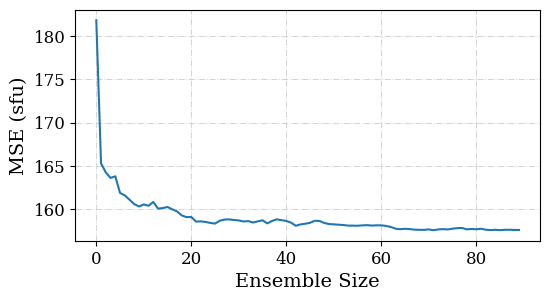

In [253]:
rel_fs = 12

fig, axes = plt.subplots(1, 1, figsize=(6,3))

x = range(len(incremental_error))

#axes.grid(True)
axes.plot(x, incremental_error, color=col["b"])
#axes.scatter(x, incremental_error, color=col["b"])

axes.tick_params(axis='x', labelsize=rel_fs)
axes.tick_params(axis='y', labelsize=rel_fs)

axes.set_xlabel("Ensemble Size", fontsize=rel_fs+2)
axes.set_ylabel("MSE (sfu)", fontsize=rel_fs+2)

#plt.title("Horizon {} days".format(horizon), fontsize=rel_fs+2)

axes.grid(linestyle='-.', linewidth=0.7, color="lightgrey", zorder=0)

#plotname = "{}/Fig3_ensemble_size_H{}".format(plotdir, horizon)
#plt.savefig("{}.pdf".format(plotname), format='pdf', dpi=1200, bbox_inches="tight", pad_inches=0, transparent=True)
#plt.savefig("{}.png".format(plotname), format='png', dpi=1200, bbox_inches="tight", pad_inches=0, transparent=True)

plt.show()

## Plot Metric-Horizon Evolution

In [49]:
# read in from pickle for faster plotting
fname1 = "{}/metrics_2016-11-25-2020-10-01_opt1.pkl".format(plotdir)
fname2 = "{}/metrics_2004-12-31-2020-10-01_opt1.pkl".format(plotdir) 
with open(fname1, 'rb') as handle:
    metricsdict1 = pickle.load(handle)
with open(fname2, 'rb') as handle:
    metricsdict2 = pickle.load(handle)

In [50]:
def fget_metrics_for_6plot(metricsdict, horizons, metric, inc_esa):
    persist, esa, cls, nbeats = [], [], [], []
    for horizon in horizons:
        persist.append(metricsdict[horizon]["PERSISTENCE"][metric])
        cls.append(metricsdict[horizon]["CLS"][metric])
        nbeats.append(metricsdict[horizon]["N-BEATS"][metric])
        if inc_esa:
            esa.append(metricsdict[horizon]["ESA"][metric])
            
    return persist, esa, cls, nbeats

In [64]:
def fplot_indiv(metricsdict, horizons, metric, metric_idx, ax, inc_esa, rel_fs=12, legend=False, xl=True, yl=True):
    
    persist, esa, cls, nbeats = fget_metrics_for_6plot(metricsdict, horizons, metric_idx, inc_esa)
    #print(len(persist), len(esa), len(cls), len(nbeats))
    
    labels = horizons
    x = np.arange(len(labels))  # the label locations

    if inc_esa:
        width = 0.15
        gap = 0.03
        w1 = x - 3 * width/2 - 3*gap/2
        w2 = x - 1 * width/2 - gap/2
        w3 = x + 1 * width/2 + gap/2
        w4 = x + 3 * width/2 + 3*gap/2
    else:
        width = 0.15
        gap = 0.03
        w1 = x - width - gap
        w3 = x
        w4 = x + width + gap

    a = 0.7
    ax.bar(w1, persist, width, label="Persistence", color=col["g"], zorder=3, alpha=a)#, yerr=persist_std, capsize=5)
    if inc_esa:
        ax.bar(w2, esa, width, label="BGS", color=col["b"], zorder=3, alpha=a)
    ax.bar(w3, cls, width, label="CLS", color=col["o"], zorder=3, alpha=a)
    ax.bar(w4, nbeats, width, label="N-BEATS", color=col["r"], zorder=3, alpha=a)
    
    if xl:
        ax.set_xlabel("Horizon (days)", fontsize=rel_fs+2)
    
    if metric in ["MSE", "RMSE", "MAE"]:
        label = "{} (sfu)".format(metric)
    else:
        label = metric
        
    if yl:
        ax.set_ylabel(label, fontsize=rel_fs+2)
        ax.get_yaxis().set_label_coords(-0.08,0.5) # 0.08, 0.09
       
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='x', labelsize=rel_fs)
    ax.tick_params(axis='y', labelsize=rel_fs)

    if legend:
        ax.legend(loc=0, prop={'size': rel_fs-1}) #-1, loc=7,10

    ax.grid(linestyle='-.', linewidth=0.7, color="lightgrey", zorder=0)

In [62]:
horizons = list(sorted(data_valid.keys()))
horizons

[3, 5, 7, 10, 14, 21, 27]

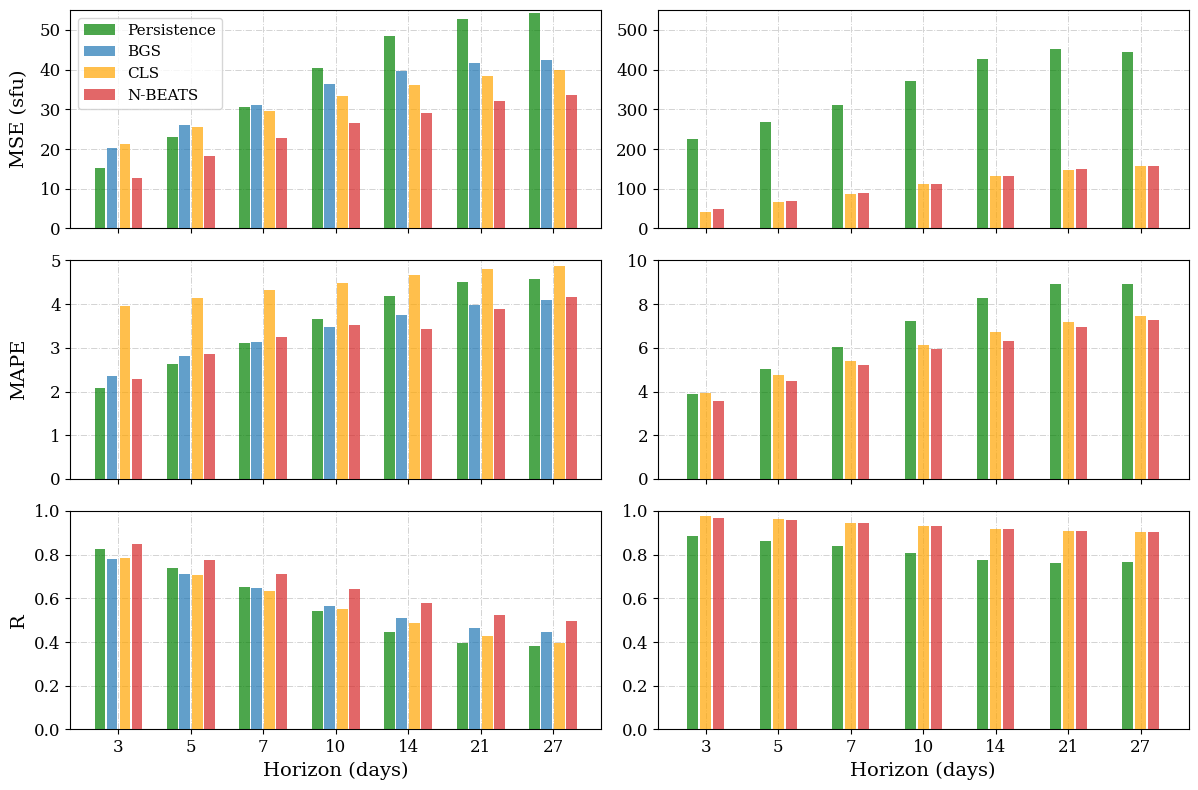

In [53]:
# barplot with all 6 figures

rel_fs = 12

fig, axes = plt.subplots(3, 2, figsize=(12,8), sharex=True) # 12,10

# metric with activity
ax = axes[0][0]
fplot_indiv(metricsdict1, horizons, "MSE", 0, ax, inc_esa=True, rel_fs=rel_fs, legend=True, xl=False, yl=True)
ax.set_ylim((0,55))

ax = axes[1][0]
fplot_indiv(metricsdict1, horizons, "MAPE", 1, ax, inc_esa=True, rel_fs=rel_fs, legend=False, xl=False, yl=True)
ax.set_ylim((0,5))

ax = axes[2][0]
fplot_indiv(metricsdict1, horizons, "R", 2, ax, inc_esa=True, rel_fs=rel_fs, legend=False, xl=True, yl=True)
ax.set_ylim((0,1))

ax = axes[0][1]
fplot_indiv(metricsdict2, horizons, "MSE", 0, ax, inc_esa=False, rel_fs=rel_fs, legend=False, xl=False, yl=False)
ax.set_ylim((0,550))

ax = axes[1][1]
fplot_indiv(metricsdict2, horizons, "MAPE", 1, ax, inc_esa=False, rel_fs=rel_fs, legend=False, xl=False, yl=False)
ax.set_ylim((0,10))

ax = axes[2][1]
fplot_indiv(metricsdict2, horizons, "R", 2, ax, inc_esa=False, rel_fs=rel_fs, legend=False, xl=True, yl=False)
ax.set_ylim((0,1))


plt.tight_layout()

#plotname = "{}/Fig5_allmetrics".format(plotdir)
#plt.savefig("{}.pdf".format(plotname), format='pdf', dpi=1200, bbox_inches="tight", pad_inches=0, transparent=True)
#plt.savefig("{}.png".format(plotname), format='png', dpi=1200, bbox_inches="tight", pad_inches=0, transparent=True)

plt.show()

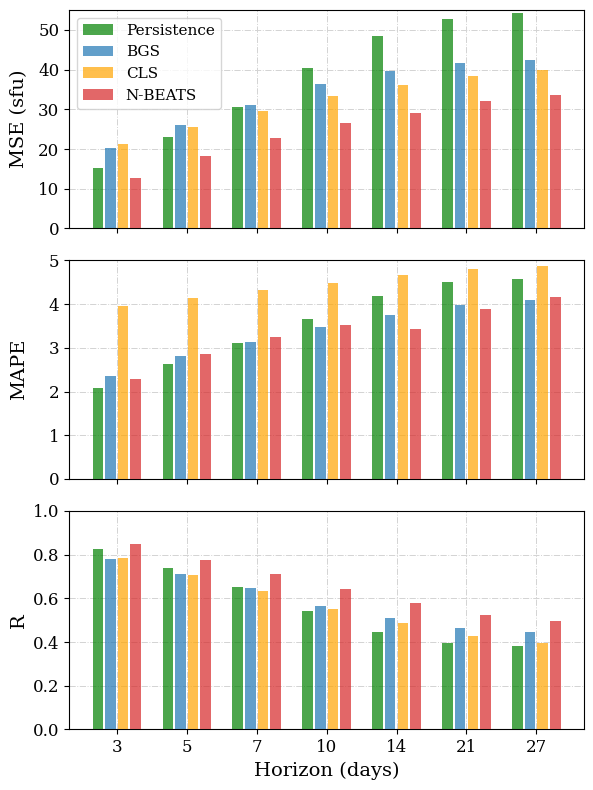

In [65]:
# barplot with all 3 figures 2016-2020

rel_fs = 12

fig, axes = plt.subplots(3, 1, figsize=(6,8), sharex=True) # 12,10

# metric with activity
ax = axes[0]
fplot_indiv(metricsdict1, horizons, "MSE", 0, ax, inc_esa=True, rel_fs=rel_fs, legend=True, xl=False, yl=True)
ax.set_ylim((0,55))

ax = axes[1]
fplot_indiv(metricsdict1, horizons, "MAPE", 1, ax, inc_esa=True, rel_fs=rel_fs, legend=False, xl=False, yl=True)
ax.set_ylim((0,5))

ax = axes[2]
fplot_indiv(metricsdict1, horizons, "R", 2, ax, inc_esa=True, rel_fs=rel_fs, legend=False, xl=True, yl=True)
ax.set_ylim((0,1))

plt.tight_layout()

plotname = "{}/Fig5a_allmetrics".format(plotdir)
plt.savefig("{}.pdf".format(plotname), format='pdf', dpi=1200, bbox_inches="tight", pad_inches=0, transparent=True)
plt.savefig("{}.png".format(plotname), format='png', dpi=1200, bbox_inches="tight", pad_inches=0, transparent=True)

plt.show()

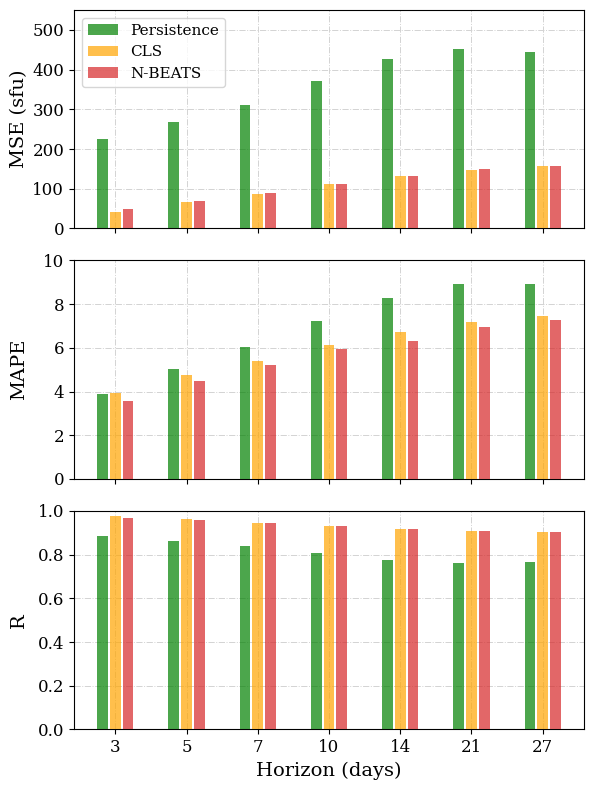

In [60]:
# barplot with all 3 figures 2006-2020

rel_fs = 12

fig, axes = plt.subplots(3, 1, figsize=(6,8), sharex=True) # 12,10

# metric with activity
ax = axes[0]
fplot_indiv(metricsdict2, horizons, "MSE", 0, ax, inc_esa=False, rel_fs=rel_fs, legend=True, xl=False, yl=True)
ax.set_ylim((0,550))

ax = axes[1]
fplot_indiv(metricsdict2, horizons, "MAPE", 1, ax, inc_esa=False, rel_fs=rel_fs, legend=False, xl=False, yl=True)
ax.set_ylim((0,10))

ax = axes[2]
fplot_indiv(metricsdict2, horizons, "R", 2, ax, inc_esa=False, rel_fs=rel_fs, legend=False, xl=True, yl=True)
ax.set_ylim((0,1))


plt.tight_layout()

plotname = "{}/Fig5b_allmetrics".format(plotdir)
plt.savefig("{}.pdf".format(plotname), format='pdf', dpi=1200, bbox_inches="tight", pad_inches=0, transparent=True)
plt.savefig("{}.png".format(plotname), format='png', dpi=1200, bbox_inches="tight", pad_inches=0, transparent=True)

plt.show()

## Plot Correlation Heatmap

2d histogram of predicted vs observed to give indication of correlation

In [ ]:
# this should be with limit_date == False

In [91]:
def fplot_corhist(fig, ax, preds, targs):
    """
    plot 2d histogram of predicted vs observed to give indication of correlation
    for a given axis
    """
    x = targs.flatten()
    y = preds.flatten()
    
    # get heatmap
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
    #extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]] # want plotted image to be square so ideal fit goes through 0

    # get ideal y=x fit
    x_perfect, y_perfect = range(int(min(x)), int(max(x))), range(int(min(x)), int(max(x)))

    # get regression line using scikit learn
    x_l = x.reshape(-1, 1)
    y_l = y.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(x_l, y_l)
    y_reg = linear_regressor.predict(x_l)

    # plot
    ax.set_title("Horizon {} days".format(horizon))
    #ax.set_xlabel("Observed F10.7")
    #ax.set_ylabel("Predicted F10.7")
    ax.plot(x_perfect, y_perfect, "k--", label="Ideal Fit")
    ax.plot(x, y_reg, "g-", label="Obtained Fit") # "r--"
    
    # #cmap="Blues", "jet", "bone", "BuPu", "YlOrRd"
    # https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
    im = ax.imshow(heatmap.T, extent=extent, origin='lower', cmap="YlOrRd", norm=mpl.colors.LogNorm())
    #norm=colors.LogNorm(vmin=heatmap.min(), vmax=heatmap.max()),
    
    ax.set_xlim([65, 260]) #[None, 265]
    ax.set_ylim([65, 260]) #[None, 265]
    
    #fig.colorbar(im, ax=ax)#, shrink=0.5) # probably want one colorbar for whole fig
    #ax.grid(True)
    ax.grid(linestyle='-.', linewidth=0.7, color="lightgrey", zorder=0)
    ax.set_aspect('equal')
    plt.legend() # prop={'size': rel_fs-1})
    
    return im

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


2 2
(5183, 3) (5183, 3)
(5177, 7) (5177, 7)
(5167, 14) (5167, 14)
(5149, 27) (5149, 27)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


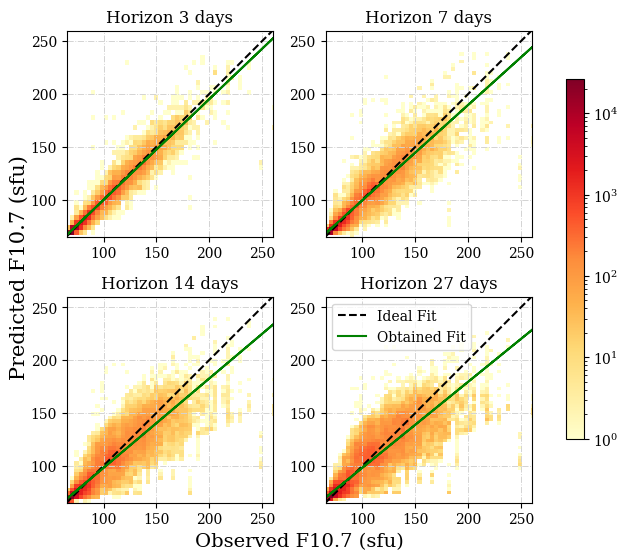

In [93]:
# presentation style with bigger fonts

# this is hardcoded really for 4 plots
horizons = [3,7,14,27] #sorted(list(predictions.keys()))

# set up subplot grid
rv = GridStrategy.get_grid(len(horizons))
nrows, ncols = max(rv), len(rv)
print(nrows, ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(6,6))#, sharex=True, sharey=True)
axs = np.array(axes).flatten()

# plot for different horizons
for plot_id, horizon in enumerate(horizons):
    #ensemble_preds, targs, epoch = predictions[horizon]
    epoch, targs, ensemble_preds, ensemble_std = predictions[horizon]
    
    print(ensemble_preds.shape, targs.shape) # this is with limit_date=True...
    
    ax = axs[plot_id]
    im = fplot_corhist(fig, ax, ensemble_preds, targs)
    
#fig.colorbar(im, ax=ax)
#fig.colorbar(im, ax=axs[-1])#axes.ravel().tolist())#, shrink=0.5)
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)

# add axis titles for whole figure
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Observed F10.7 (sfu)",fontsize=14)
plt.ylabel("Predicted F10.7 (sfu)",fontsize=15)

cbar_ax = fig.add_axes([1.01, 0.25, 0.03, 0.6]) # adjust size of colorbar here
fig.colorbar(im, cax=cbar_ax, shrink=0.3)

plt.tight_layout()
#fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
#try:
#    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5) # must be after tightlayout
#except AttributeError:
#    fig.colorbar(im, ax=ax, shrink=0.85)
#plt.tight_layout()

#plt.subplots_adjust(wspace=0.2, hspace=0.2)
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax, shrink=0.3)

plotname = "{}/Fig8_correlation_heatmap".format(plotdir)
plt.savefig("{}.pdf".format(plotname), format='pdf', dpi=1200, bbox_inches="tight", pad_inches=0, transparent=True)
plt.savefig("{}.png".format(plotname), format='png', dpi=1200, bbox_inches="tight", pad_inches=0, transparent=True)

plt.show()

# normalise colorbar?

## Plot Model Bias

In [105]:
# this needs option 1

In [106]:
# split solar activity into subsections to compare with cls
# error (real-pred) (sfu) for one year periods but only up to 7 days
# mean error and standard deviation of error

In [107]:
horizon = 7

In [108]:
activity = {
    "LOW"  : [["2019-01-01", "2019-12-31"]],
    "INC"  : [["2011-05-01", "2012-04-30"]],
    "HIGH" : [["2013-09-30", "2014-09-29"]],
    "DEC"  : [["2016-08-31", "2017-08-30"]],
}

In [109]:
# get N-BEATS mean error and std in error for a given horizon

def fget_nbeats(date, horizon, predictions):
    
    ldate, udate = date
    
    ensemble_epochs, ensemble_targs, ensemble_preds, ensemble_stds = predictions[horizon]

    larg = np.argwhere(ensemble_epochs==ldate)[0][0]
    uarg = np.argwhere(ensemble_epochs==udate)[0][0] + 1
    #print(larg, uarg)
    print(ensemble_epochs[larg], ensemble_epochs[uarg])

    preds = ensemble_preds[larg:uarg]
    targs = ensemble_targs[larg:uarg]

    return preds, targs

In [110]:
# compare to CLS

def fget_cls(date, horizon, df):
    
    ldate, udate = date
    
    # restrict predictions to horizon size
    dfcls = pd.DataFrame()
    for gendate in np.unique(df.gendate):
        #print(dff[dff.gendate == "2017-01-01"][:horizon])
        dfcls = dfcls.append(df[df.gendate == gendate][:horizon], ignore_index = True)

    # drop gendates that don't give full forcast (depends on horizon)
    dfcls = dfcls[dfcls.groupby('gendate').gendate.transform('count')>=horizon].copy()

    # restrict to date period
    dfcls = dfcls[dfcls.gendate >= ldate][dfcls.gendate <= udate]
    
    def fchunk(lst, n):
        return np.array([lst[i:i + n] for i in range(0, len(lst), n)])
    
    preds = fchunk(np.array(dfcls["y_cls"]), horizon)
    targs = fchunk(np.array(dfcls["y_cls_true"]), horizon)

    return preds, targs

In [112]:
def fget_bias(preds, targs):
    """
    here use preds - targs as in Liemohn
    makes more sense that negative bias is underprediction
    (not targs - preds as in Yaya)
    """
    
    bias = preds - targs
    mean_bias = np.mean(bias, axis=0)
    mean_biasstd = np.std(bias, axis=0)
    print(mean_bias.shape, mean_biasstd.shape)
    
    return mean_bias, mean_biasstd

In [113]:
for key in activity.keys():
    
    date = activity[key][0]
    
    # option 1
    preds, targs = fget_nbeats(date, horizon, predictions)
    predscls, targscls = fget_cls(date, horizon, df)

    mean_bias, mean_biasstd = fget_bias(preds, targs)
    mean_biascls, mean_biasstdcls = fget_bias(predscls, targscls)
    mean_biasmix, mean_biasstdmix = fget_bias(preds, targscls) # compare N-BEATS predictions to CLS cleaned dataset
    
    activity[key].append([mean_bias, mean_biasstd, mean_biascls, mean_biasstdcls, mean_biasmix, mean_biasstdmix])

2019-01-01 2020-01-01


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(7,) (7,)
(7,) (7,)
(7,) (7,)
2011-05-01 2012-05-01


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(7,) (7,)
(7,) (7,)
(7,) (7,)
2013-09-30 2014-09-30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(7,) (7,)
(7,) (7,)
(7,) (7,)
2016-08-31 2017-08-31
(7,) (7,)
(7,) (7,)
(7,) (7,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [114]:
activity

{'LOW': [['2019-01-01', '2019-12-31'],
  [array([1.07039561, 0.9555026 , 1.28433842, 1.38705877, 1.17551904,
          1.76769303, 1.14675744]),
   array([1.30688056, 1.65625654, 1.90448153, 2.086603  , 2.212325  ,
          2.29383313, 2.34771049]),
   array([-3.67506849, -3.16876712, -2.91863014, -2.43780822, -2.21808219,
          -2.14273973, -1.8630137 ]),
   array([2.91604119, 3.07455485, 3.22837306, 3.29617389, 3.30861087,
          3.30106386, 3.2780092 ]),
   array([-1.7085085 , -1.82175767, -1.49840131, -1.39677685, -1.60502891,
          -1.01148506, -1.64091379]),
   array([2.77903413, 2.9328874 , 3.09359133, 3.23432307, 3.34138987,
          3.41753364, 3.48843866])]],
 'INC': [['2011-05-01', '2012-04-30'],
  [array([ 0.43809486,  0.04779528,  0.23536323,  0.19102021, -0.42569711,
          -0.17828798, -1.06670135]),
   array([ 5.92592773,  8.61401038, 10.52096507, 12.14137512, 13.74286995,
          15.03934586, 16.02250979]),
   array([0.54863388, 0.61092896, 0.80519126

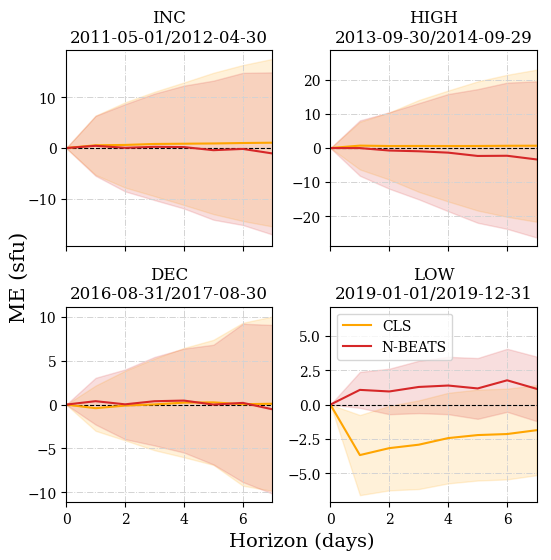

In [118]:
from matplotlib.ticker import MaxNLocator

fig, axes = plt.subplots(2, 2, figsize=(6,6), sharex=True)#, sharey=True)
axs = np.array(axes).flatten()

for plot_id, key in enumerate(["INC", "HIGH", "DEC", "LOW"]):
    
    y, sigma, ycls, sigmacls, ymix, sigmamix = activity[key][1]
    x = range(0, horizon+1)
    y = np.insert(y, 0, 0)
    sigma = np.insert(sigma, 0, 0)
    ycls = np.insert(ycls, 0, 0)
    sigmacls = np.insert(sigmacls, 0, 0)
    
    ax = axs[plot_id]
    ax.plot()
    
    ax.plot(x, [0 for i in x], linestyle="--", color="k", linewidth=0.8)
    
    ax.plot(x, ycls, col["o"], label="CLS")
    #ax.scatter(range(0, horizon+1), np.insert(ycls, 0, 0), col["o"])
    #ax.plot(x, ycls + sigmacls, col["o"], linestyle="--", alpha=0.7)
    #ax.plot(x, ycls - sigmacls, col["o"], linestyle="--", alpha=0.7)
    ax.fill_between(x, ycls-sigmacls, ycls+sigmacls, color=col["o"], alpha=0.15)
    #ax.errorbar(x, ycls, sigmacls, linestyle='-', capsize=5, color=col["o"], label="CLS CNES")
    
    ax.plot(x, y, color=col["r"], label="N-BEATS")
    #ax.scatter(range(0, horizon+1), np.insert(y, 0, 0), color=col["r"])
    #ax.plot(x, y + sigma, col["r"], linestyle="--", alpha=0.7)
    #ax.plot(x, y - sigma, col["r"], linestyle="--", alpha=0.7)
    ax.fill_between(x, y-sigma, y+sigma, color=col["r"], alpha=0.15)
    #ax.errorbar(x, y, sigma, linestyle='-', capsize=5, color=col["r"], label="N-BEATS")

    #ax.grid(True)
    ax.grid(linestyle='-.', linewidth=0.7, color="lightgrey", zorder=0)
    ax.set_title("{}\n{}/{}".format(key, activity[key][0][0], activity[key][0][1]))
    
    ax.set_xlim([0, horizon])
    ax.xaxis.set_major_locator(MaxNLocator(5, integer=True))
    
    if plot_id == 3:
        ax.legend(loc=2)#4)
    # want 0 to be in the middle
    l, u = ax.get_ylim()
    bound = max(abs(l), u)
    ax.set_ylim([-bound, bound])

# add axis titles for whole figure
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Horizon (days)",fontsize=14)
plt.ylabel("ME (sfu)",fontsize=15)

plt.xlim([0, horizon])

plt.tight_layout()

plotname = "{}/Fig7_bias_plot_H{}".format(plotdir, horizon)
plt.savefig("{}.pdf".format(plotname), format='pdf', dpi=1200, bbox_inches="tight", pad_inches=0, transparent=True)
plt.savefig("{}.png".format(plotname), format='png', dpi=1200, bbox_inches="tight", pad_inches=0, transparent=True)

plt.show()

## Plot triple plot of MSE and rel MSE with Solar Activity

In [177]:
# needs option 2: just for h=10 not averaged over all

In [178]:
def fchunk(lst, n):
    return [lst[i:i + n] for i in range(0, len(lst), n)]

In [179]:
# split epochs into smaller arrays of size e.g. 1 year
window_size = 180 #365 # days

In [180]:
#horizons = list(sorted(data_valid.keys()))
#horizons = range(1,28)
#horizons = predictions.keys()
horizons = [10]
horizons

[10]

In [181]:
date_error = {}
date_uncertainty = {}

predictions = copy.deepcopy(predictions1)["N-BEATS"] # option 2

for model in ["N-BEATS", "N-BEATS-C"]:
    
    date_error[model] = {}
    date_uncertainty[model] = {}
    
    if model == "N-BEATS":
        predictions_std = copy.deepcopy(predictions_opt1)["N-BEATS"] # option 1
    if model == "N-BEATS-C":
        predictions_std = copy.deepcopy(predictions_calstd) # option 1 (needs to be for multiple horizons)

    for horizon in horizons:
        ensemble_epochs, ensemble_targs, ensemble_preds, _ = predictions[horizon] # option 2
        _, _, _, ensemble_std = predictions_std[horizon]
        ensemble_std = ensemble_std[:,horizon-1] # take last --> option 2

        # split into date chunks
        nepochs = fchunk(ensemble_epochs, window_size)

        dates = []
        mses  = []
        stds  = []

        # for each date chunk calculate error
        for year in nepochs:
            ldate, udate = year[0], year[-1]
            #print(ldate, udate)
            larg = np.argwhere(ensemble_epochs==ldate)[0][0]
            uarg = np.argwhere(ensemble_epochs==udate)[0][0] + 1
            #print(larg, uarg)
            preds = ensemble_preds[larg:uarg]
            targs = ensemble_targs[larg:uarg]
            std   = ensemble_std[larg:uarg]

            mses.append(fmse(preds, targs))
            dates.append(ensemble_epochs[larg + int(0.5*(uarg-larg))])
            #stds.append(np.mean(std[:,1])) # for option 1
            stds.append(np.mean(std)) # for option 2

        date_error[model][horizon] = [dates, mses]
        date_uncertainty[model][horizon] = [dates, stds]

In [182]:
# plot in comparison to external metrics

predictions_ext = copy.deepcopy(predictions1)["external"]
#predictions_ext = copy.deepcopy(predictions_opt1)["external"]

external_date_error = {}
external_sigma = {}

# need to restrict to horizon then chunk
for horizon in horizons:
    
    dff = predictions_ext[horizon]
    
    # restrict predictions to horizon size
    #dff = pd.DataFrame()
    #for gendate in np.unique(df.gendate):
    #    #print(dff[dff.gendate == "2017-01-01"][:horizon])
    #    dff = dff.append(df[df.gendate == gendate][:horizon], ignore_index = True)

    # limit to same period as have for N-BEATS predictions
    #lnbeats, unbeats = str(predictions[horizon][0][0]), str(predictions[horizon][0][-1])
    #dff = dff[dff.gendate >= lnbeats][dff.gendate <= unbeats].reset_index(drop=True)
        
    # drop gendates that don't give full forcast (depends on horizon)
    #dff = dff[dff.groupby('gendate').gendate.transform('count')>=horizon].copy()
    
    # split into date chunks based on gendate
    nepochs = fchunk(np.unique(dff.gendate), window_size)
    
    mses = []
    mses_persist = []
    dates = []
    sigmacls = []

    for year in nepochs:
        ldate, udate = year[0], year[-1]
        #print(ldate, udate)
        preds   = dff[dff.gendate >= ldate][dff.gendate < udate]["y_cls"].values
        targs   = dff[dff.gendate >= ldate][dff.gendate < udate]["y_cls_true"].values
        #persist = dff[dff.gendate >= ldate][dff.gendate < udate]["persistence_cls"].values
        persist   = dff[dff.gendate >= ldate][dff.gendate < udate]["persistence_esa"].values
        targs_esa = dff[dff.gendate >= ldate][dff.gendate < udate]["y_esa_true"].values
        
        f107p = dff[dff.gendate >= ldate][dff.gendate < udate]["f10.7_p"].values
        sigmacls.append(np.mean(f107p))
        
        # replace anomalous spikes in data
        for i in repl.keys():
            persist = np.where(persist==i, repl[i], persist)
            targs_esa = np.where(targs_esa==i, repl[i], targs_esa)

        errorobj = cErrorMetrics()
        mses.append(errorobj.fmse(preds, targs))
        mses_persist.append(errorobj.fmse(persist, targs_esa))
        dates.append(ldate + 0.5*(udate-ldate))

    external_date_error[horizon] = [dates, mses, mses_persist]
    external_sigma[horizon] = [dates, sigmacls]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

In [188]:
dates1, _ = external_sigma[horizon]

ldate = str(dates1[0]) #dt.datetime.strptime(dates1[0],'%Y-%m-%d').date() #"1950-01-01"
udate = str(dates1[-1]) #dt.datetime.strptime(dates1[-1],'%Y-%m-%d').date() #"2020-01-01"

dataobj = cESA_SWE()
dfa_esa = dataobj.fget_data(filenames="../data/archive/F10.7DailyObservedFluxDensity.txt")["f10_7"]
dfa_esa.set_index('ds', inplace=True)
df_lim = dfa_esa[ldate:udate]
df_daily = dataobj.fget_daily(df_lim, "20:00")
dfa_esa  = dataobj.fmissing_data(df_daily, "interp_linear")
dfa_esa

,y
ds,
2007-01-21,78.6
2007-01-22,78.5
2007-01-23,79.3
2007-01-24,80.4
2007-01-25,79.9
...,...
2020-08-31,69.2
2020-09-01,69.5
2020-09-02,68.3


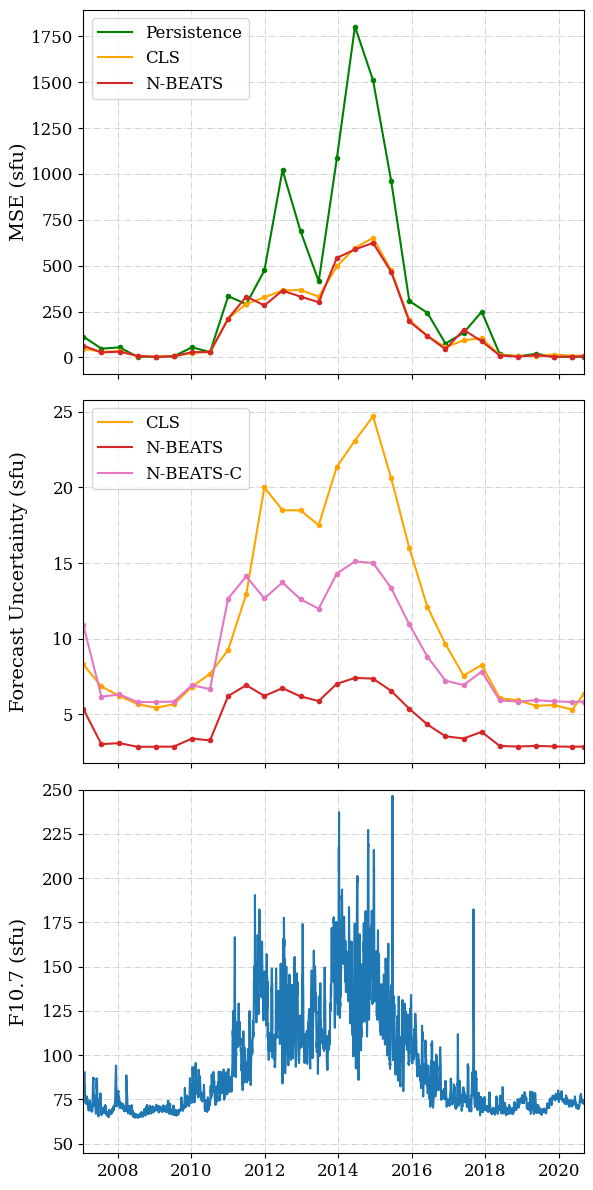

In [195]:
# plot all together
# H=10, average=180
horizon = 10

rel_fs = 12

fig, axes = plt.subplots(3, 1, figsize=(6, 12), sharex=True)#, sharey=True) # 5, 10

# metric with activity
ax = axes[0]
d1, msen = date_error["N-BEATS"][horizon]
d2, msec, msep = external_date_error[horizon]
x1 = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in d1]
ax.plot(x1, msep, ".", color=col["g"])
ax.plot(x1, msep, "-", color=col["g"], label="Persistence")
ax.plot(x1, msec, ".", color=col["o"])
ax.plot(x1, msec, "-", color=col["o"], label="CLS")
ax.plot(x1, msen, ".", color=col["r"])
ax.plot(x1, msen, "-", color=col["r"], label="N-BEATS")
ax.grid(linestyle='-.', linewidth=0.7, color="lightgrey", zorder=0)
ax.tick_params(axis='x', labelsize=rel_fs)
ax.tick_params(axis='y', labelsize=rel_fs)
ax.legend(loc=2, prop={'size': rel_fs})
ax.set_ylabel("MSE (sfu)", fontsize=rel_fs+2)
ax.get_yaxis().set_label_coords(-0.11,0.5)

# solar activity
ax = axes[2]
ax.plot(dfa_cls, col["b"]) # dfa_cls, dfa_esa
ax.tick_params(axis='x', labelsize=rel_fs)
ax.tick_params(axis='y', labelsize=rel_fs)
ax.grid(linestyle='-.', linewidth=0.7, color="lightgrey", zorder=0)
ax.set_xlim([x1[0], x1[-1]])
ax.set_ylim([None, 250]) # 50
ax.set_ylabel("F10.7 (sfu)", fontsize=rel_fs+2)
ax.get_yaxis().set_label_coords(-0.11,0.5)

# uncertainty CLS vs N-BEATS
ax = axes[1]
d3, stds1 = date_uncertainty["N-BEATS"][horizon]
d4, stds2 = date_uncertainty["N-BEATS-C"][horizon]
d5, stds3 = external_sigma[horizon]
x1, y1 = d3, stds1
x2, y2 = d4, stds2
x3, y3 = d5, stds3
ax.plot(x3, y3, ".", color=col["o"])
ax.plot(x3, y3, "-", color=col["o"], label="CLS")
ax.plot(x3, y1, ".", color=col["r"])
ax.plot(x3, y1, "-", color=col["r"], label="N-BEATS")
ax.plot(x3, y2, ".", color=col["x"])
ax.plot(x3, y2, "-", color=col["x"], label="N-BEATS-C")
ax.grid(linestyle='-.', linewidth=0.7, color="lightgrey", zorder=0)
ax.tick_params(axis='x', labelsize=rel_fs)
ax.tick_params(axis='y', labelsize=rel_fs)
ax.legend(loc=2, prop={'size': rel_fs})
ax.set_ylabel("Forecast Uncertainty (sfu)", fontsize=rel_fs+2) # 1$\sigma$ 
ax.get_yaxis().set_label_coords(-0.11,0.5)

plt.tight_layout()

plotname = "{}/Fig6_triple_activity_plot_{}".format(plotdir, horizon)
plt.savefig("{}.pdf".format(plotname), format='pdf', dpi=1200, bbox_inches="tight", pad_inches=0, transparent=True)
plt.savefig("{}.png".format(plotname), format='png', dpi=1200, bbox_inches="tight", pad_inches=0, transparent=True)

plt.show()

## Uncertainty: Calibrate

In [36]:
# need to cut data so same length or cut at given date range (to be compared with esa etc)
limit_date = True

In [37]:
data_train.keys(), data_valid.keys()

(dict_keys([3, 7, 5, 14, 10, 27, 21]), dict_keys([3, 7, 5, 14, 10, 27, 21]))

In [38]:
def fchunk(lst, n):
    return [lst[i:i + n] for i in range(0, len(lst), n)]

In [39]:
def fensemble1(preds_valid, mode="mean"):
    """
    simple mean/median ensemble, std over ensemble
    """
    # reshape
    stack = np.dstack(preds_valid)
    
    if mode == "mean":
        ensemble_preds = np.mean(stack, axis=2)
    elif mode == "median":
        ensemble_preds = np.median(stack, axis=2)
  
    # variance in ensemble
    ensemble_std = np.std(stack, axis=2)
    #print(ensemble_std.shape)
        
    return ensemble_preds, ensemble_std

In [40]:
import scipy.integrate as integrate

def integrand(x):
    #return np.exp( -(x**2) ) / np.sqrt(np.pi)
    return np.sqrt(2*np.pi) * np.exp( (x**2) ) # /2 ?

In [41]:
def winkler_score(y, l, u, alpha):
    """
    for a single observation and prediction interval
    https://otexts.com/fpp3/distaccuracy.html
    """
    if y < l:
        w = (u - l) + (2/alpha)*(l - y)
    elif (l <= y) and (y <= u):
        w = (u - l)
    elif y > u:
        w = (u - l) + (2/alpha)*(y - u)
        
    return w

In [42]:
# check % in bound
def fin_bound(horizon, targs, preds, lbound, ubound, alpha):
    
    # need to do count for each day inside each forecast horizon
    for h_i in range(horizon):
        #print("horizon: ", h_i)

        totalcounti = len(targs[:,h_i])
        countini = 0
        ws = []
        for i in range(totalcounti):
            ws.append(winkler_score(targs[:,h_i][i], lbound[:,h_i][i], ubound[:,h_i][i], alpha)) # or 1/alpha???
            if (targs[:,h_i][i] >= lbound[:,h_i][i]) and (targs[:,h_i][i] <= ubound[:,h_i][i]):
                countini += 1

    print("Horizon = {}, std = {}, Count = {}/{}, %={}, Winkler {} +/- {}".format(h_i+1, std, countini, totalcounti, 100*countini/totalcounti, np.mean(ws), np.std(ws)))
    
    return 100*countini/totalcounti, np.mean(ws)

In [43]:
horizons = list(sorted(data_valid.keys()))

In [46]:
from scipy import special

c = 0.9
std = 1
#horizon = 10

if std == 1:
    c = 0.6827
if std == 2:
    c = 0.9545
if std == 3:
    c = 0.9973

percs_cls, percs_nbeats, percs_nbeats_cal = [], [], []
ws_cls, ws_nbeats, ws_nbeats_cal = [], [], []

predictions_calstd = {}

cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for horizon in [27]:#horizons:
    print("\n\nHorizon: ", horizon)
    
    for c in cs:#[0.8]:#cs:
        print("\n\n c: ", c)

        # 1. get external
        df_external = predictions_opt1["external"][horizon]

        external_preds = np.array(fchunk(df_external["y_cls"].values, horizon))
        external_std = np.array(fchunk(df_external["f10.7_p"].values, horizon))
        external_targs = np.array(fchunk(df_external["y_cls_true"].values, horizon))
        print(external_preds.shape, external_std.shape, external_targs.shape)

        # 2. get n-beats
        epoch_train, preds_train, targs_train = fget_preds(data_train[horizon])
        epoch_valid, preds_valid, targs_valid = fget_preds(data_valid[horizon], limit_date, lcompdate, ucompdate)

        # replace anomalous spikes in data
        for i in repl.keys():
            targs_train = np.where(targs_train==i, repl[i], targs_train)
            targs_valid = np.where(targs_valid==i, repl[i], targs_valid)

        # ensemble and store predictions and uncertainty or prediction interval
        ensemble_preds, ensemble_std = fensemble1(preds_valid, mode="mean")
        ensemble_preds_train, ensemble_std_train = fensemble1(preds_train, mode="mean")
        #print(preds_valid.shape, ensemble_preds.shape, ensemble_std.shape, targs_valid.shape)

        # get calibration
        #gamma = 1
        gamma = np.sqrt( np.sum((ensemble_preds_train - targs_train)**2, axis=0) / np.sum(ensemble_std_train**2, axis=0) )
        gamma = np.mean(gamma) # per horizon (model), or overall
        print(gamma)
        print(gamma.shape)

        # new std x calibration
        ensemble_std_cal = np.multiply(ensemble_std, gamma)
        #print(ensemble_std_cal.shape)
        #print(np.mean(ensemble_std_cal, axis=0))

        predictions_calstd[horizon] = epoch_valid, targs_valid, ensemble_preds, ensemble_std_cal # need for triple plot

        # 3. get interval
        d_g = np.sqrt(2) * special.erfinv(c)
        #print(d_g)

        # 4. external
        print("\nCLS")
        lbound1 = external_preds - d_g*external_std
        ubound1 = external_preds + d_g*external_std   
        perc1, w1 = fin_bound(horizon, external_targs, external_preds, lbound1, ubound1, 1-c)
        percs_cls.append(perc1)
        ws_cls.append(w1)

        # 5. n-beats without correction
        print("\nN-BEATS")
        lbound2 = ensemble_preds - d_g*ensemble_std
        ubound2 = ensemble_preds + d_g*ensemble_std
        perc2, w2 = fin_bound(horizon, targs_valid, ensemble_preds, lbound2, ubound2, 1-c)
        percs_nbeats.append(perc2)
        ws_nbeats.append(w2)
        
        # 5. n-beats with correction
        print("\nN-BEATS + CORRECTION")
        lbound3 = ensemble_preds - d_g*ensemble_std_cal
        ubound3 = ensemble_preds + d_g*ensemble_std_cal
        perc3, w3 = fin_bound(horizon, targs_valid, ensemble_preds, lbound3, ubound3, 1-c)
        percs_nbeats_cal.append(perc3)
        ws_nbeats_cal.append(w3)



Horizon:  27


 c:  0.1
(5085, 27) (5085, 27) (5085, 27)
(90, 20595, 27) 1950-06-12 2006-10-30
(90, 5085, 27) 2006-10-31 2020-10-01
2.2781517757871024
()

CLS
Horizon = 27, std = 1, Count = 576/5085, %=11.327433628318584, Winkler 19.5232723571831 +/- 23.44364410914351

N-BEATS
Horizon = 27, std = 1, Count = 253/5085, %=4.975417895771878, Winkler 18.86246879558465 +/- 24.05645970198153

N-BEATS + CORRECTION
Horizon = 27, std = 1, Count = 571/5085, %=11.229105211406097, Winkler 18.824845675011353 +/- 23.9539604598017


 c:  0.2
(5085, 27) (5085, 27) (5085, 27)
(90, 20595, 27) 1950-06-12 2006-10-30
(90, 5085, 27) 2006-10-31 2020-10-01
2.2781517757871024
()

CLS
Horizon = 27, std = 1, Count = 1206/5085, %=23.716814159292035, Winkler 21.428709359932498 +/- 25.636071620880863

N-BEATS
Horizon = 27, std = 1, Count = 517/5085, %=10.16715830875123, Winkler 20.921291259795634 +/- 26.928252809565887

N-BEATS + CORRECTION
Horizon = 27, std = 1, Count = 1139/5085, %=22.3992133726647, Winkler 20.7

In [47]:
np.mean(gamma)

2.2781517757871024

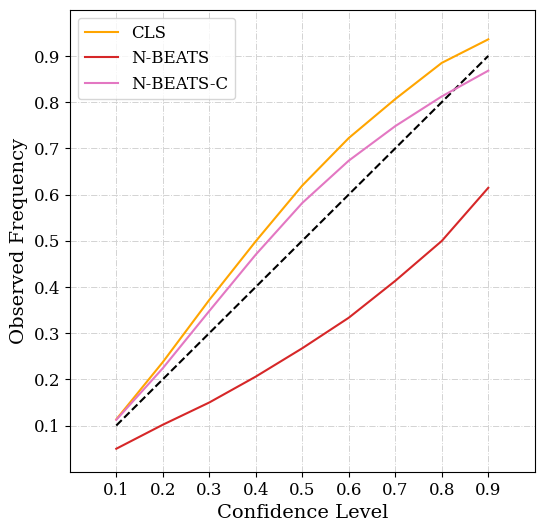

In [50]:
rel_fs = 12

fig, ax = plt.subplots(figsize=(6,6)) # 5,5

ax.plot(cs, np.array(percs_cls)/100, label="CLS", color=col["o"], zorder=4)
ax.plot(cs, np.array(percs_nbeats)/100, label="N-BEATS", color=col["r"], zorder=4)
ax.plot(cs, np.array(percs_nbeats_cal)/100, label="N-BEATS-C", color=col["x"], zorder=4)
ax.plot(cs, cs, "k--", zorder=3)#, label="Ideal Calibration")

ax.xaxis.set_ticks(np.arange(0.1, 1.0, 0.1))
ax.yaxis.set_ticks(np.arange(0.1, 1.0, 0.1))

ax.tick_params(axis='x', labelsize=rel_fs)
ax.tick_params(axis='y', labelsize=rel_fs)

ax.legend(prop={'size': rel_fs}, loc="upper left")

ax.set_ylabel("Observed Frequency", fontsize=rel_fs+2)
ax.set_xlabel("Confidence Level", fontsize=rel_fs+2) # confidence #

#ax.set_xlim((dt.datetime(1950,1,1),None))
ax.set_xlim((0,1.0))
ax.set_ylim((0,1.0))
ax.grid(linestyle='-.', linewidth=0.7, color="lightgrey", zorder=0)

plotname = "{}/Fig9_reliability_diagram_H{}".format(plotdir, horizon)
plt.savefig("{}.pdf".format(plotname), format='pdf', dpi=1200, bbox_inches="tight", pad_inches=0, transparent=True)
plt.savefig("{}.png".format(plotname), format='png', dpi=1200, bbox_inches="tight", pad_inches=0, transparent=True)

plt.show()

In [505]:
c = 0.9545
np.sqrt(2) * special.erfinv(c)

2.000002443899603